In [165]:
# Data Processing and model code
# import necessary packages

import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import time
import datetime
from pathlib import Path
import glob

tf.random.set_seed(1234)

path="wiki_crop/00"
# load dataset
with open((str(path)+"\\"+"labaled_data.json"), "r") as outfile:
            data = json.load(outfile)

classes = set()
for i in data:
    classes.add(data.get(i)[1])
classes = list(classes)

<IPython.core.display.Javascript object>


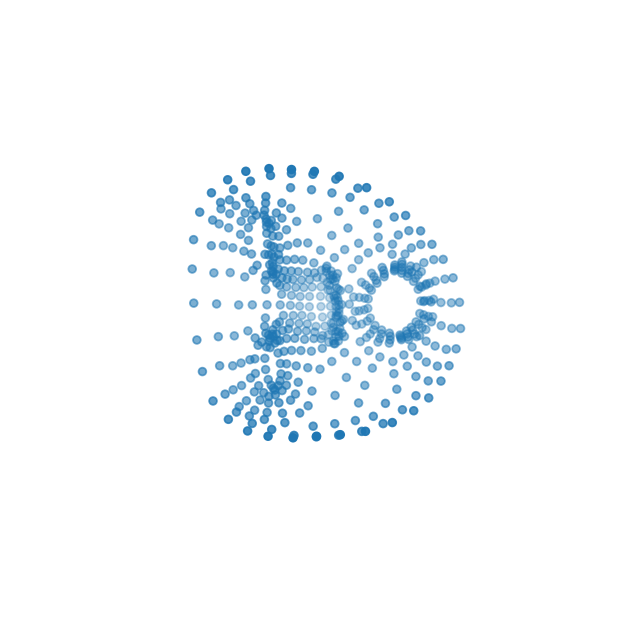

In [166]:
%matplotlib notebook
points = np.array(data.get(list(data.keys())[2])[0])
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [167]:
def parse_split_dataset(data, classes, num_points=478):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = classes

    for i in enumerate(list(data.keys())):
        if i[0] < int(len(list(data.keys()))*0.7):
            train_points.append(data.get(i[1])[0])
            train_labels.append(classes.index(data.get(i[1])[1]))
        else:
            test_points.append(data.get(i[1])[0])
            test_labels.append(classes.index(data.get(i[1])[1]))
        
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )


In [169]:
NUM_POINTS = 478
NUM_CLASSES = 2
BATCH_SIZE = 16

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_split_dataset(data, classes, NUM_POINTS)

In [170]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


In [171]:
train_dataset

<BatchDataset shapes: ((None, 478, 3), (None,)), types: (tf.float64, tf.int32)>

In [172]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [173]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        super().__init__()
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({
#             'num_features': self.num_features,
#             'l2reg': self.l2reg,
#             'eye': tf.eye(num_features)
#         })
#         return config

In [174]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


In [175]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 478, 3)]     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 478, 32)      128         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 478, 32)      128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 478, 32)      0           batch_normalization_51[0][0]     
___________________________________________________________________________________________

In [185]:
try:
    model.load_weights("./")
except:
    print("no model data")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=100, validation_data=test_dataset)
model.save_weights("./")

Epoch 1/100
19/19 [==============================] - 4s 63ms/step - loss: 1.1695 - sparse_categorical_accuracy: 0.7419 - val_loss: 1.5713 - val_sparse_categorical_accuracy: 0.5591
Epoch 2/100
19/19 [==============================] - 1s 42ms/step - loss: 1.2228 - sparse_categorical_accuracy: 0.5601 - val_loss: 1.8237 - val_sparse_categorical_accuracy: 0.5748
Epoch 3/100
19/19 [==============================] - 1s 45ms/step - loss: 1.1736 - sparse_categorical_accuracy: 0.6371 - val_loss: 1.2741 - val_sparse_categorical_accuracy: 0.5591
Epoch 4/100
19/19 [==============================] - 1s 41ms/step - loss: 1.2442 - sparse_categorical_accuracy: 0.5080 - val_loss: 6.9465 - val_sparse_categorical_accuracy: 0.4094
Epoch 5/100
19/19 [==============================] - 1s 45ms/step - loss: 1.2477 - sparse_categorical_accuracy: 0.5282 - val_loss: 2.0642 - val_sparse_categorical_accuracy: 0.5354
Epoch 6/100
19/19 [==============================] - 1s 42ms/step - loss: 1.2419 - sparse_categorica

19/19 [==============================] - 1s 44ms/step - loss: 1.2379 - sparse_categorical_accuracy: 0.4675 - val_loss: 1.6086 - val_sparse_categorical_accuracy: 0.5039
Epoch 47/100
19/19 [==============================] - 1s 42ms/step - loss: 1.2235 - sparse_categorical_accuracy: 0.5349 - val_loss: 1.3216 - val_sparse_categorical_accuracy: 0.4016
Epoch 48/100
19/19 [==============================] - 1s 44ms/step - loss: 1.2096 - sparse_categorical_accuracy: 0.5438 - val_loss: 1.2380 - val_sparse_categorical_accuracy: 0.4567
Epoch 49/100
19/19 [==============================] - 1s 44ms/step - loss: 1.2084 - sparse_categorical_accuracy: 0.5440 - val_loss: 1.3464 - val_sparse_categorical_accuracy: 0.4567
Epoch 50/100
19/19 [==============================] - 1s 40ms/step - loss: 1.2200 - sparse_categorical_accuracy: 0.5765 - val_loss: 1.2698 - val_sparse_categorical_accuracy: 0.5433
Epoch 51/100
19/19 [==============================] - 1s 45ms/step - loss: 1.2265 - sparse_categorical_accur

19/19 [==============================] - 1s 48ms/step - loss: 1.1794 - sparse_categorical_accuracy: 0.6294 - val_loss: 5.4794 - val_sparse_categorical_accuracy: 0.4961
Epoch 92/100
19/19 [==============================] - 1s 48ms/step - loss: 1.2094 - sparse_categorical_accuracy: 0.5791 - val_loss: 1.2668 - val_sparse_categorical_accuracy: 0.5276
Epoch 93/100
19/19 [==============================] - 1s 45ms/step - loss: 1.1953 - sparse_categorical_accuracy: 0.5641 - val_loss: 148.0352 - val_sparse_categorical_accuracy: 0.5827
Epoch 94/100
19/19 [==============================] - 1s 47ms/step - loss: 1.1688 - sparse_categorical_accuracy: 0.6292 - val_loss: 1.8120 - val_sparse_categorical_accuracy: 0.5906
Epoch 95/100
19/19 [==============================] - 1s 41ms/step - loss: 1.2090 - sparse_categorical_accuracy: 0.5936 - val_loss: 1.4225 - val_sparse_categorical_accuracy: 0.4803
Epoch 96/100
19/19 [==============================] - 1s 50ms/step - loss: 1.2370 - sparse_categorical_acc

<IPython.core.display.Javascript object>


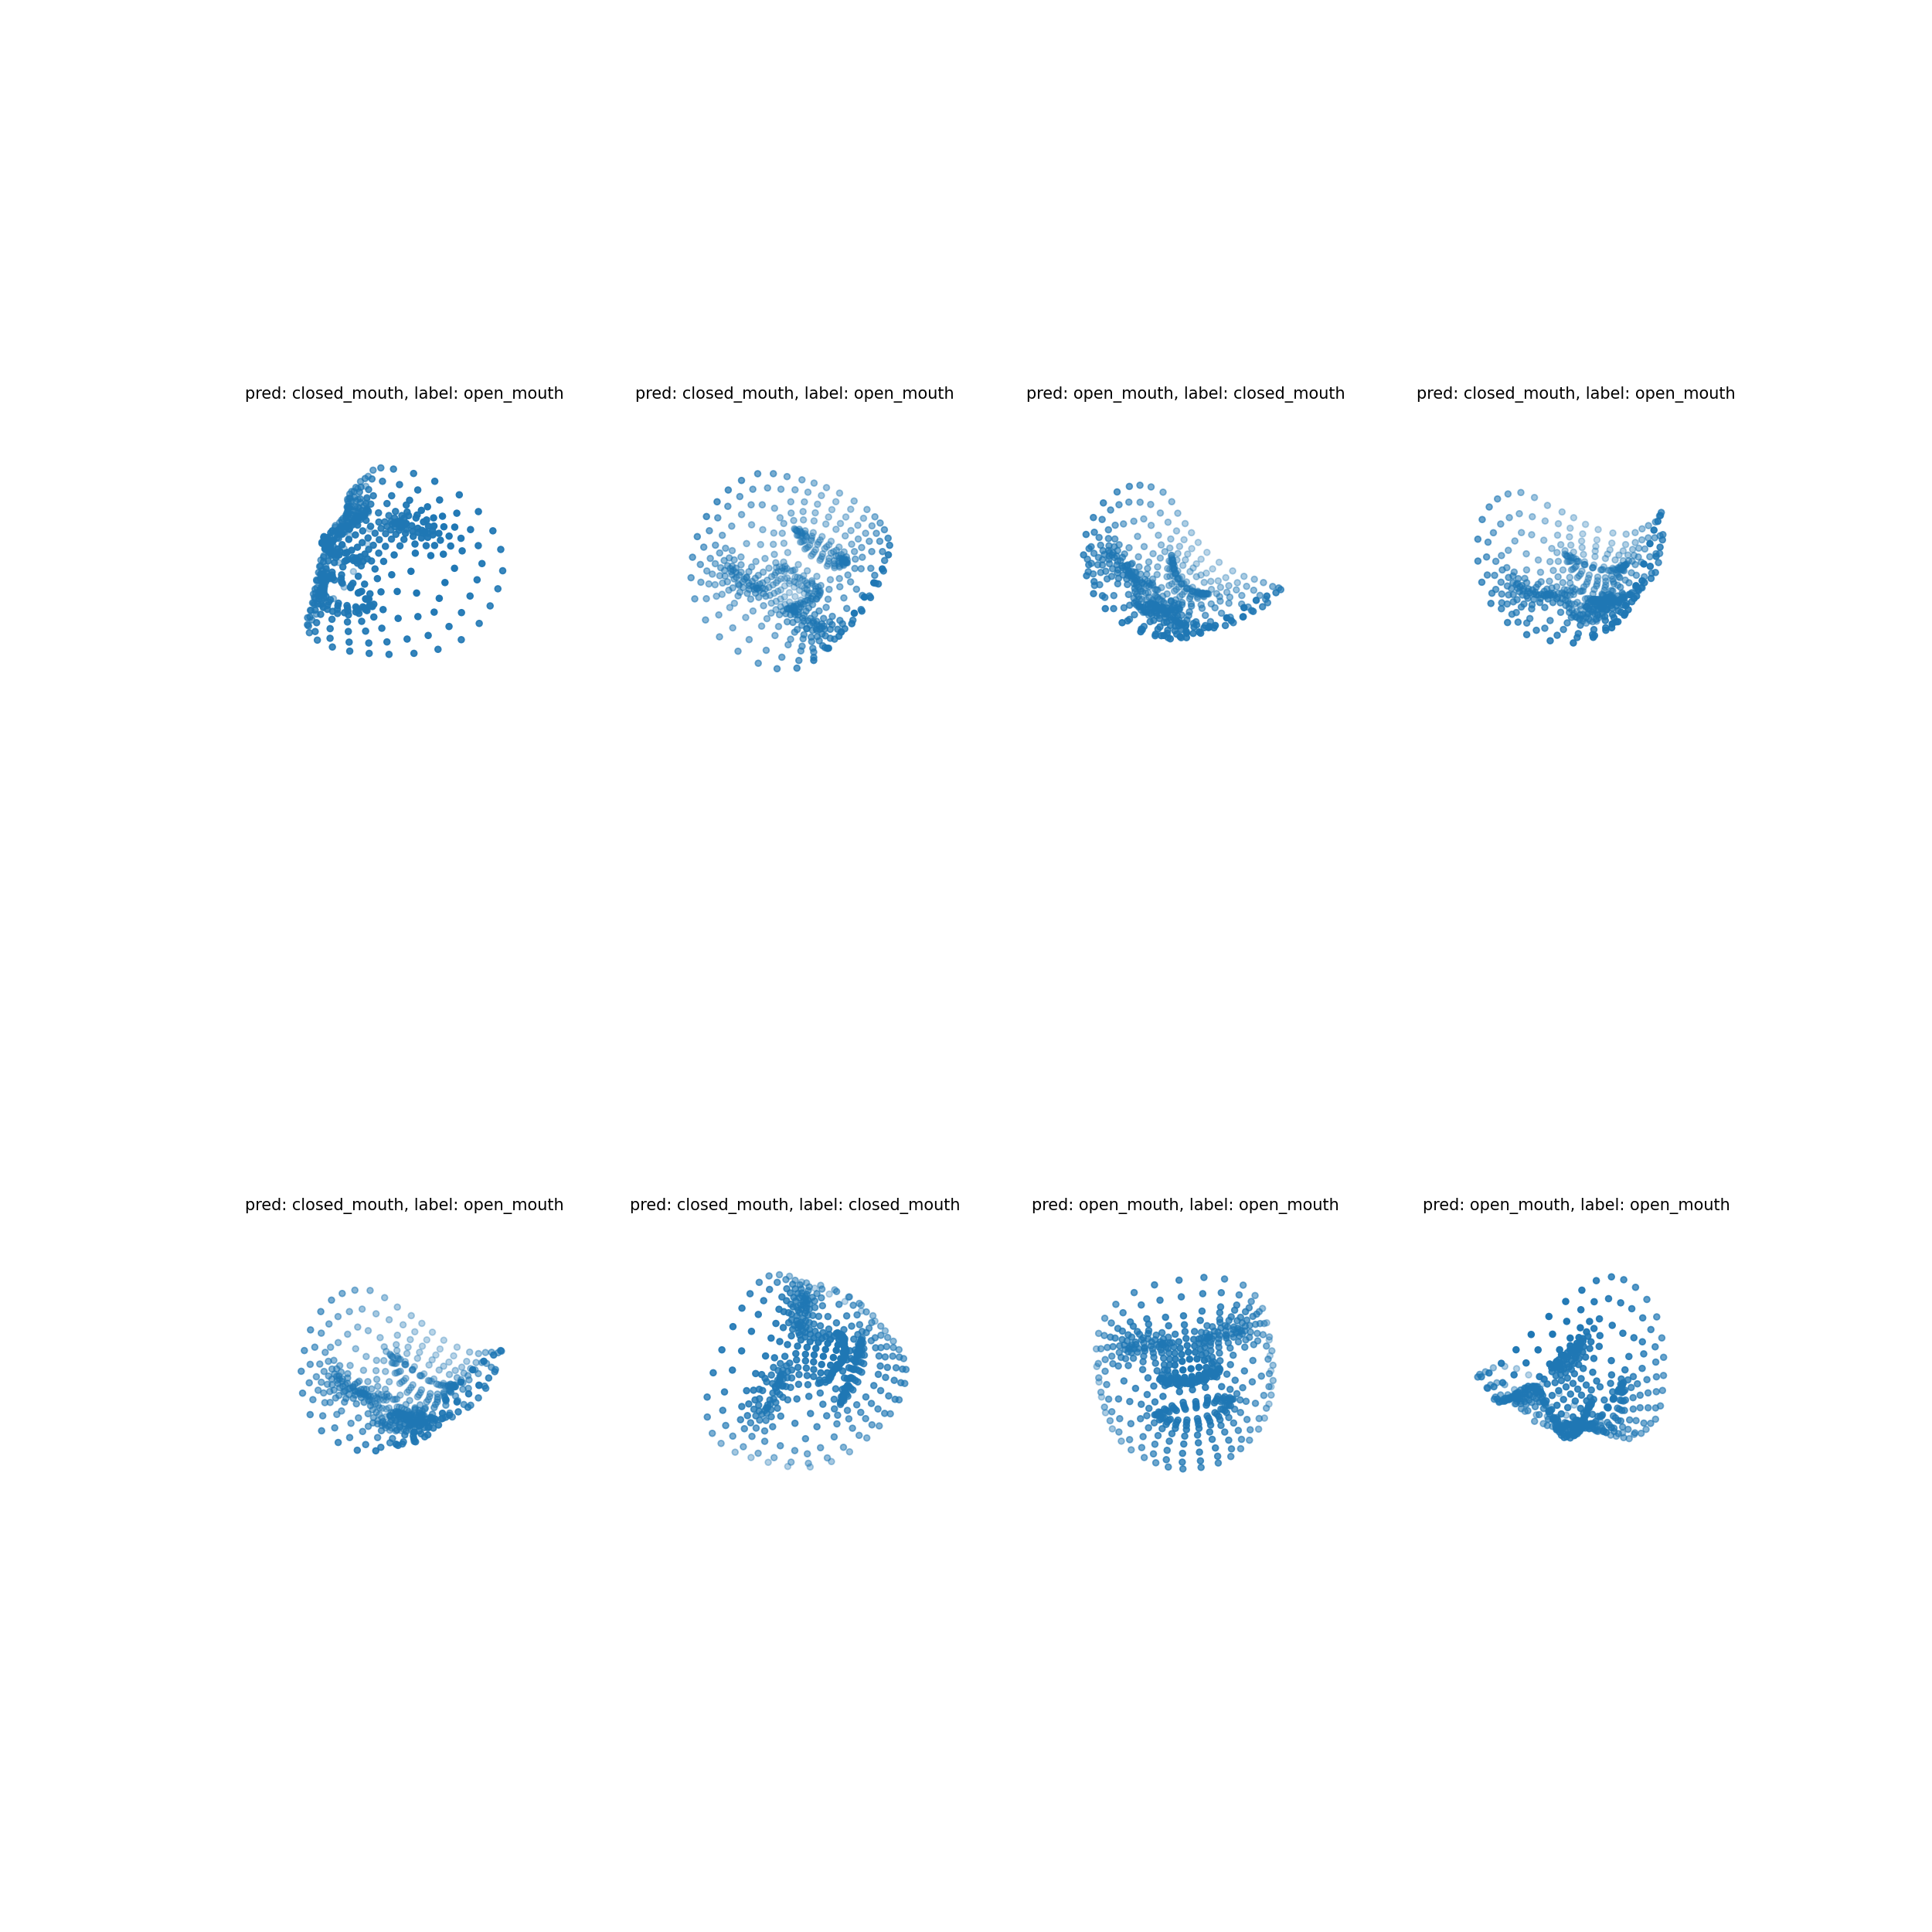

In [179]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(20, 20))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()


In [ ]:
train_points = []
for i in enumerate(list(data.keys())):
        if i[0] < int(len(list(data.keys()))*0.7):
            train_points.append(data.get(i[1])[0])

In [ ]:
display(len(train_points))